### TP Clase 5: Competición de CNN!

    Vamos a armar una pequeña competición en el curso.
    El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
    Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

    *   `test_acc` (del test final)
    *   `n_parameter`
    *   `n_layers` (conv + activacion + pooling = 1 capa)
    *   `n_epochs` de entrenamiento usadas.

    El modelo se deberá ajustar a los siguientes puntos:

    *   train: 80%, validation: 10%, test: 10% (los datos serán dados para que todos usan el mismo set para cada grupo. Están en el github el curso).
    *   capa final de salida será una softmax de 10 elementos.
    *   cost_function será `CrossEntropyLoss`.

    El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:
 
 ![equation](https://latex.codecogs.com/svg.image?score%20=%20\frac{1}{log_{10}(n\_parameter)}%20*%20\frac{10}{n\_epochs}*test\_acc*n\_layers)
  
  Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).
   
   Se armará un ranking con el score alcanzado, la red ganadora se llavará el título del campeon!
    
   Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.

In [68]:
# Importamos las librerías
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt

In [69]:
# Seleccionamos kernell 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [70]:
# Cargamos los datos
import pickle

X_test = torch.Tensor(np.resize(np.array(pickle.load( open( "/content/test.pkl", "rb" ) )), (7000, 1, 28, 28)))
y_test = torch.Tensor(np.array(pickle.load( open( "/content/test_label.pkl", "rb" ) )))
y_test = y_test.type(torch.LongTensor)
X_train = torch.Tensor(np.resize(np.array(pickle.load( open( "/content/train.pkl", "rb" ) )), (56000, 1, 28, 28)))
y_train = torch.Tensor(np.array(pickle.load( open( "/content/train_label.pkl", "rb" ))) )
y_train = y_train.type(torch.LongTensor)
X_val = torch.Tensor(np.resize(np.array(pickle.load( open( "/content/val.pkl", "rb" ) )), (7000, 1, 28, 28)))
y_val = torch.Tensor(np.array(pickle.load( open( "/content/val_label.pkl", "rb" ))) )
y_val = y_val.type(torch.LongTensor)
print('X_train: ',X_train.shape, ' y_train: ',y_train.shape)
print('X_test: ',X_test.shape, ' y_test: ',y_test.shape)
print('X_val: ',X_val.shape, ' y_val: ',y_val.shape)

X_train:  torch.Size([56000, 1, 28, 28])  y_train:  torch.Size([56000])
X_test:  torch.Size([7000, 1, 28, 28])  y_test:  torch.Size([7000])
X_val:  torch.Size([7000, 1, 28, 28])  y_val:  torch.Size([7000])


In [71]:
# Cargamos los datos y los tranformamos en tensores

from torch.utils.data import DataLoader, TensorDataset

std = np.std(np.array(pickle.load( open( "/content/test.pkl", "rb" ) )))
mean = np.mean(np.array(pickle.load( open( "/content/test.pkl", "rb" ) )))

transform=torchvision.transforms.Compose([torchvision.transforms.Normalize(mean,std)])
X_train_t = transform(X_train)
X_test_t = transform(X_test)
X_val_t = transform(X_val)
train_dataset = TensorDataset(X_train_t,y_train) 
test_dataset = TensorDataset(X_test_t,y_test) 
val_dataset = TensorDataset(X_val_t,y_val) 

dataloader = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

# Verificamos 
print(type(dataloader))
print(type(dataloader['train']))


<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


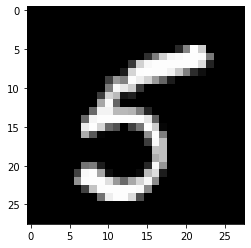

Label: 5


In [72]:
# Display image and label from dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = train_features[0].squeeze()
print('tamaño 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### IMPLEMENTAMOS NUESTRA CNN

In [73]:
# definimos  bloque de una capa CNN

# (hiper)parámetros a pasar a la función:
#   c_in:   canales (kernels) de entrada
#   c_out:  canales (kernels) de salida
#   k:      tamaño del kernel kxk
#   p:      tamaño del padding de la convolución
#   s:      stride de la convolución
#   pk:     tamaño del kernel del pooling
#   ps:     stride de la pooling
#   pp:     padding en la pooling

def block(c_in, c_out, k=3, p=2, s=1, pk=2, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp))         # pooling

In [74]:
# Armamos el objeto con nuestra red CNN
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv1_out = None
    self.conv2 = block(64, 32)
    self.conv2_out = None
    self.conv3 = block(32, 32)
    self.conv3_out = None
    self.conv4 = block(32, 32)
    self.conv4_out = None
    self.conv5 = block(32, 32)
    self.conv5_out = None
    self.conv6 = block(32, 32)
    self.conv6_out = None
    self.conv7 = block(32, 32)
    self.conv7_out = None
    self.conv8 = block(32, 32)
    self.conv8_out = None
    self.conv9 = block(32, 32)
    self.conv9_out = None
    self.conv10 = block(32, 32)
    self.conv10_out = None
    self.conv11 = block(32, 32)
    self.conv11_out = None
    self.conv12 = block(32, 32)
    self.conv12_out = None


    
    self.fc = torch.nn.Linear(512, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    #print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    #print("Tamaño salida conv3: ", x.shape)
    x = self.conv3(x)
    #print("Tamaño salida conv3: ", x.shape)

    x = self.conv4(x)
    #print("Tamaño salida conv4: ", x.shape)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.conv8(x)
    x = self.conv9(x)
    x = self.conv10(x)
    x = self.conv11(x)
    x = self.conv12(x)



    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)
    i=0
    for layer in self.children():
        i=i+1
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    return i, pytorch_total_params

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    self.conv6_out = self.conv6(self.conv5_out)
    self.conv7_out = self.conv7(self.conv6_out)
    self.conv8_out = self.conv8(self.conv7_out)
    self.conv9_out = self.conv9(self.conv8_out)
    self.conv10_out = self.conv10(self.conv9_out)
    self.conv11_out = self.conv11(self.conv10_out)
    self.conv12_out = self.conv12(self.conv11_out)


    y = self.conv12_out.view(self.conv12_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [75]:
# Creamos la instancia del modelo

model3 = CNN()


Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, paddi

In [76]:
# Observamos nuestro modelo y creamos nuestras variables que servirán para la métrica fina:
n_layer, n_parameter = model3.validar_dim()
print('cantidad de parametros entrenables:', n_parameter)
print('cantidad de capas del modelo:', n_layer)

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 64, 16, 16])
Tamaño imagen vectorizada:  torch.Size([1, 512])
Tamaño salida fc (nro clases):  torch.Size([1, 10])
cantidad de parametros entrenables: 116714
cantidad de capas del modelo: 13


In [77]:
# Definimos la funcion de entrenamiento:

from tqdm import tqdm # <- para graficar la barra de avance
n_epochs = 1
lr = 1e-3
def fit(m, dataloader, epochs=n_epochs):
    m.to(device)
    optimizer = torch.optim.Adam(m.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        m.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = m(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['val'])
        val_loss, val_acc = [], []
        m.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = m(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
        

In [78]:
# Entrenamos la red:
fit(model3, dataloader)

val_loss 0.17180 val_acc 0.95014: 100%|██████████| 110/110 [00:00<00:00, 152.76it/s]

Epoch 1/1 loss 0.82178 val_loss 0.17180 acc 0.70537 val_acc 0.95014


In [79]:
criterion = torch.nn.CrossEntropyLoss()
with torch.no_grad():
    model3.eval()
    X_test_t, y_test = X_test_t.to(device), y_test.to(device)
    y_pred = model3(X_test_t)
    test_loss = criterion(y_pred, y_test)
    acc = (y_test == torch.argmax(y_pred, axis=1)).sum().item() / len(y_test)
print('El Accuracy para el set de Test es de {} y la Loss es de {}'.format(acc,test_loss))

El Accuracy para el set de Test es de 0.952 y la Loss es de 0.18120110034942627


In [80]:
# Ahora calculamos la métrica del concurso:
n_layers = 12
SCORE12 = (1 / np.log10(n_parameter)) * (10/n_epochs) * acc * n_layers
print('EL SCORE ES DE', SCORE12)

EL SCORE ES DE 22.545338064861145


## CONCLUSIONES: Como el peso de aumentar la cantidad de capas es mayor que el log10 de la cantidad de parámetros, utilizando 32 filtros para cada capa, lo mas conveniente es llevar al máximo la cantidad de capas.
## Para ello utilicé la configuración de stride y padding (tanto en la capa de convolución como la de padding), que me permitan tener tantos layers como quiera porque converge en matrices de 4x4.
## El problema es que llega un punto que al seguir aumentando las layers cae mucho el desempeño del modelo, debido a la gran cantidad de peso que tiene el padding en las capas finales.